# 훈련 모델 예측 시각화

In [4]:
# -*- coding: utf-8 -*-
import os,sys
sys.path.append(os.getcwd())
import torch
from model.unet_model import Ringed_Res_Unet # 사용 모델
from dataset.Defacto import test # defacto 데이터셋 한정 테스트 모듈
import torch.nn.functional as F
import torch.nn as nn
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# RRU-Net pre-trained
# rru_net = Ringed_Res_Unet().cuda()
# rru_net.load_state_dict(torch.load('../RRUNet/best_model.pth'))
rru_net = Ringed_Res_Unet().cuda()
rru_net.load_state_dict(torch.load('./result/logs/defactor/Ringed_Res_Unet/defactor-[val_dice]-0.7420-[train_loss]-0.0753.pkl')) # copy-move / epoch = 100, (800,256,256,3), batch 6 
# rru_net.load_state_dict(torch.load('./result/logs/defactor/Ringed_Res_Unet/sp_100_defactor-[val_dice]-0.4487-[train_loss]-1.3824.pkl')) # splicing / epoch = 100, (800,256,256,3), batch 6 

<All keys matched successfully>

2000
torch.Size([1, 3, 256, 256])
torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


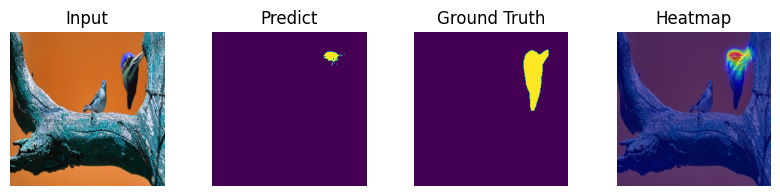

In [7]:
INDEX =  102# 100
MODE = 'te1st' # 'any' : no purmute , no normalize / 'test' same 'train' condition
DIR_IMG = r"E:\splicing_2_img\img"
DIR_MASK = r"E:\splicing_2_annotations\probe_mask"
IMG_SIZE = 256

device = torch.device("cuda:0")
pred,img,mask = test(rru_net,device,INDEX,MODE,IMG_SIZE,DIR_IMG,DIR_MASK)
if MODE not in ['test','train']:
    img = img.permute(1,2,0)
    
print(img.shape)

pred = F.sigmoid(pred)

pred_ = pred[0,:,:,:]
pred_ = pred_.permute(1,2,0)
pred_ = pred_.to('cpu').detach().numpy()

plt.figure(figsize=(10,2))
plt.subplot(141)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(pred_>0.5)#,cmap='jet',interpolation='nearest')
plt.title('Predict')
plt.axis('off')
plt.subplot(143)
plt.imshow(mask)
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(144)
plt.imshow(img)
plt.imshow(pred_.squeeze(-1) ,alpha=0.6,cmap='jet')
plt.title('Heatmap')
plt.axis('off')
plt.show()

In [32]:
a = torch.Tensor(np.array([[1,2,3,4,5],[6,7,8,9,10]]))
b = torch.Tensor(np.array([1,2,3,4,5]))
c = torch.Tensor(np.array([2,5,6,7,8]))


image = np.zeros((256,256,3))
label = np.zeros((256,256))

print(image.shape)
label.shape

a = 3
b = 2

a,b = (b,a)
print(a,b)

(256, 256, 3)
2 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


heatmap m n :  tensor(1.8058e-06) tensor(1.)
heatmap m n :  0 255 (256, 256)
heatmap m n :  0 255
im m n :  0.0 1.0


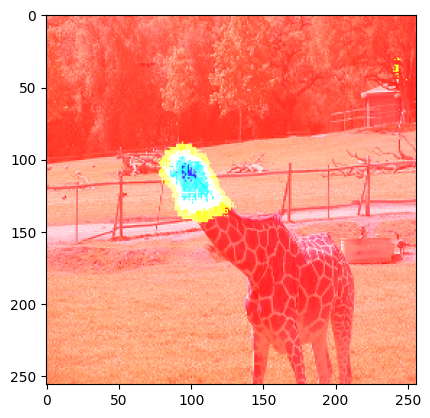

In [12]:
heatmap = torch.mean(pred.to('cpu'), dim=1).squeeze()
heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
print('heatmap m n : ',heatmap.min(),heatmap.max())
heatmap = np.uint8(heatmap*255)
print('heatmap m n : ',heatmap.min(),heatmap.max(),heatmap.shape)
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
print('heatmap m n : ',heatmap.min(),heatmap.max())
im = img.numpy()
im = (im-im.min())
im = (im/im.max())

print('im m n : ',im.min(),im.max())
heatmap_img = (heatmap*0.4 + im)
# cv.imshow('Jet',heatmap_img)
# cv.waitKey(0)
# cv.destroyAllWindows()
plt.imshow(heatmap_img)
plt.show()

In [ ]:
from torchsummary import summary
summary(rru_net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         GroupNorm-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
         GroupNorm-5         [-1, 32, 256, 256]              64
   RRU_double_conv-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 32, 256, 256]              96
         GroupNorm-8         [-1, 32, 256, 256]              64
              ReLU-9         [-1, 32, 256, 256]               0
           Conv2d-10          [-1, 3, 256, 256]              96
           Conv2d-11         [-1, 32, 256, 256]             896
        GroupNorm-12         [-1, 32, 256, 256]              64
             ReLU-13         [-1, 32, 256, 256]               0
           Conv2d-14         [-1, 32, 2

In [ ]:
print(rru_net)

Ringed_Res_Unet(
  (down): RRU_first_down(
    (conv): RRU_double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 32, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (4): GroupNorm(32, 32, eps=1e-05, affine=True)
      )
    )
    (relu): ReLU(inplace=True)
    (res_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): GroupNorm(32, 32, eps=1e-05, affine=True)
    )
    (res_conv_back): Sequential(
      (0): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (down1): RRU_down(
    (conv): RRU_double_conv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (2): ReLU(inpla

In [ ]:
print('# generator parameters:', 1.0 * sum(param.numel() for param in rru_net.parameters())/1000000)
params = list(rru_net.named_parameters())
for i in range(len(params)):
    (name, param) = params[i]
    print(name)
    print(param.shape)
    

# generator parameters: 4.097249
down.conv.conv.0.weight
torch.Size([32, 3, 3, 3])
down.conv.conv.0.bias
torch.Size([32])
down.conv.conv.1.weight
torch.Size([32])
down.conv.conv.1.bias
torch.Size([32])
down.conv.conv.3.weight
torch.Size([32, 32, 3, 3])
down.conv.conv.3.bias
torch.Size([32])
down.conv.conv.4.weight
torch.Size([32])
down.conv.conv.4.bias
torch.Size([32])
down.res_conv.0.weight
torch.Size([32, 3, 1, 1])
down.res_conv.1.weight
torch.Size([32])
down.res_conv.1.bias
torch.Size([32])
down.res_conv_back.0.weight
torch.Size([3, 32, 1, 1])
down1.conv.conv.0.weight
torch.Size([64, 32, 3, 3])
down1.conv.conv.0.bias
torch.Size([64])
down1.conv.conv.1.weight
torch.Size([64])
down1.conv.conv.1.bias
torch.Size([64])
down1.conv.conv.3.weight
torch.Size([64, 64, 3, 3])
down1.conv.conv.3.bias
torch.Size([64])
down1.conv.conv.4.weight
torch.Size([64])
down1.conv.conv.4.bias
torch.Size([64])
down1.res_conv.0.weight
torch.Size([64, 32, 1, 1])
down1.res_conv.1.weight
torch.Size([64])
down1.r

In [1]:
import jpegio
import PIL.Image as Image
import numpy as np

def get_jpeg_info( im_path:str):
        """
        :param im_path: JPEG image path
        :return: DCT_coef (Y,Cb,Cr), qtables (Y,Cb,Cr)
        """
        num_channels =  3#self.DCT_channels
        if im_path[-3:] == "tif":
            print('tiff file')
            outfile = "./test.jpg"
            im = Image.open(im_path)
            out = im.convert("RGB")
            out.save(outfile, "JPEG", quality=90)

        jpeg = jpegio.read(str(outfile))

        # determine which axes to up-sample
        ci = jpeg.comp_info
        need_scale = [[ci[i].v_samp_factor, ci[i].h_samp_factor] for i in range(num_channels)]
        if num_channels == 3:
            if ci[0].v_samp_factor == ci[1].v_samp_factor == ci[2].v_samp_factor:
                need_scale[0][0] = need_scale[1][0] = need_scale[2][0] = 2
            if ci[0].h_samp_factor == ci[1].h_samp_factor == ci[2].h_samp_factor:
                need_scale[0][1] = need_scale[1][1] = need_scale[2][1] = 2
        else:
            need_scale[0][0] = 2
            need_scale[0][1] = 2

        # up-sample DCT coefficients to match image size
        DCT_coef = []
        for i in range(num_channels):
            r, c = jpeg.coef_arrays[i].shape
            coef_view = jpeg.coef_arrays[i].reshape(r//8, 8, c//8, 8).transpose(0, 2, 1, 3)
            # case 1: row scale (O) and col scale (O)
            if need_scale[i][0]==1 and need_scale[i][1]==1:
                out_arr = np.zeros((r * 2, c * 2))
                out_view = out_arr.reshape(r * 2 // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
                out_view[::2, ::2, :, :] = coef_view[:, :, :, :]
                out_view[1::2, ::2, :, :] = coef_view[:, :, :, :]
                out_view[::2, 1::2, :, :] = coef_view[:, :, :, :]
                out_view[1::2, 1::2, :, :] = coef_view[:, :, :, :]

            # case 2: row scale (O) and col scale (X)
            elif need_scale[i][0]==1 and need_scale[i][1]==2:
                out_arr = np.zeros((r * 2, c))
                DCT_coef.append(out_arr)
                out_view = out_arr.reshape(r*2//8, 8, c // 8, 8).transpose(0, 2, 1, 3)
                out_view[::2, :, :, :] = coef_view[:, :, :, :]
                out_view[1::2, :, :, :] = coef_view[:, :, :, :]

            # case 3: row scale (X) and col scale (O)
            elif need_scale[i][0]==2 and need_scale[i][1]==1:
                out_arr = np.zeros((r, c * 2))
                out_view = out_arr.reshape(r // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
                out_view[:, ::2, :, :] = coef_view[:, :, :, :]
                out_view[:, 1::2, :, :] = coef_view[:, :, :, :]

            # case 4: row scale (X) and col scale (X)
            elif need_scale[i][0]==2 and need_scale[i][1]==2:
                out_arr = np.zeros((r, c))
                out_view = out_arr.reshape(r // 8, 8, c // 8, 8).transpose(0, 2, 1, 3)
                out_view[:, :, :, :] = coef_view[:, :, :, :]

            else:
                raise KeyError("Something wrong here.")

            DCT_coef.append(out_arr)

        # quantization tables
        qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]

        return DCT_coef, qtables

In [2]:
dct,qtables = get_jpeg_info(r"C:\Users\zxcas\PythonWork\DATASETS\Forgery\copymove_img\img\0_000000000071.tif")
print(dct)
print(qtables)

tiff file
[array([[61.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[69.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[-65.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])]
[array([[ 3.,  2.,  2.,  3.,  5.,  8., 10., 12.],
       [ 2.,  2.,  3.,  4.,  5., 12., 12., 11.],
       [ 3.,  3.,  3

C:\Users\zxcas\AppData\Local\Temp\ipykernel_6264\9212371.py:73: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]
